In [9]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Data uploading

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Time, seconds      600000 non-null  float64
 1   Series values, dB  600000 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 9.2 MB


In [4]:
df.columns

Index(['Time, seconds', 'Series values, dB'], dtype='object')

In [5]:
df.shape

(600000, 2)

In [6]:
df.head()

,"Time, seconds","Series values, dB"
0,0.0000,-117
1,0.0001,46
2,0.0002,-478
3,0.0003,2
4,0.0004,4


In [4]:
df.isnull().sum()

Time    0
dB      0
dtype: int64

In [7]:
df.rename(columns={'Time, seconds':'Time','Series values, dB':'dB'},inplace=True)

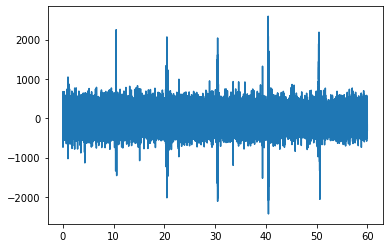

In [ ]:
plt.plot(df['Time'], df['dB'])

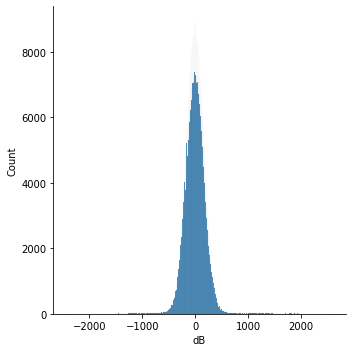

In [ ]:
sns.displot(df['dB'])

In [ ]:
df['dB'].mean()

0.42299166666666665

In [ ]:
df['dB'].median()

-1.0

In [ ]:
df['dB'].std()

206.05923793187685

In [ ]:
df['dB'].skew()

0.562562595900459

In [ ]:
df['dB'].kurtosis()

16.274066715697536

# Checking Normality

## Q-Q plot

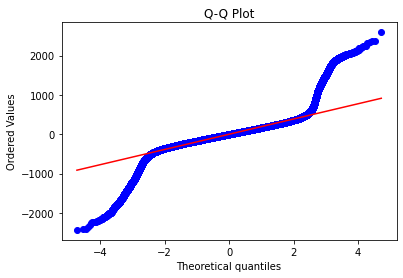

In [ ]:
import scipy as sp

f,ax = plt.subplots()
_,(_,_,r)= sp.stats.probplot(df['dB'],plot=ax)
ax.set_title('Q-Q Plot')
plt.show()

## Statistical tests, Shapiro-Wilk and Ktest

In [ ]:
from scipy.stats import kstest, norm
ks_statistic, p_value = kstest(df['dB'], 'norm')
print(ks_statistic, p_value)

0.49384176863503654 0.0


In [ ]:
from scipy.stats import shapiro
shapiro(df['dB'])

ShapiroResult(statistic=0.881129801273346, pvalue=0.0)

## Checking with Z score value

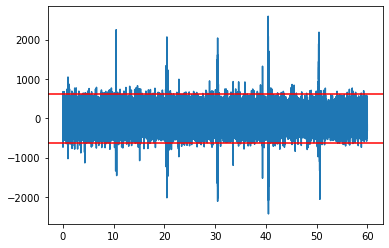

In [ ]:
mean = df['dB'].mean()
std = df['dB'].std()

upper_bound= mean + 3*std
lower_bound= mean - 3*std

plt.plot('Time','dB',data=df)
plt.axhline(lower_bound,color='r')
plt.axhline(upper_bound,color='r')

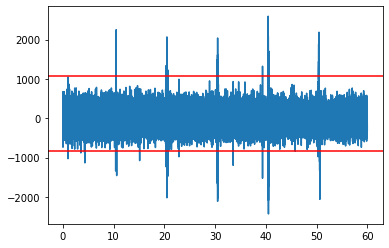

In [ ]:
low = np.percentile(df['dB'],0.3)
up = np.percentile(df['dB'],99.7)
plt.plot('Time','dB',data=df)
plt.axhline(low,color='r')
plt.axhline(up,color='r')

In normal distribution, "mean + 3*std" should be equal to the 99.7th percentile value, but graphs does not match. It means data is not normal distributed.

# Anomaly detection with statistical threshold

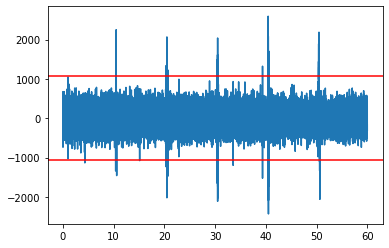

In [ ]:
low = np.percentile(df['dB'],0.2)
upper = np.percentile(df['dB'],99.7)

plt.plot('Time','dB',data=df)
plt.axhline(low,color='r')
plt.axhline(upper,color='r')

In [ ]:
q1, q3 = np.percentile(df['dB'],[25,75])
IQR = q3-q1
low = q1 - IQR*1.5
up = q3 + 1.5*IQR

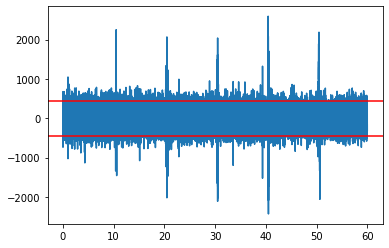

In [ ]:
plt.plot('Time','dB',data=df)
plt.axhline(low,color='r')
plt.axhline(up,color='r')

IQR method gives lower threshold for anomalies. Thus, i will apply moving average to denoise data.

In [ ]:
data = df.copy()
ma = 10
data['dB'] = data['dB'].rolling(ma).mean()
data = data.loc[ma:,:]
q1, q3 = np.percentile(data['dB'],[25,75])
IQR = q3-q1
low = q1 - IQR*1.5
up = q3 + 1.5*IQR

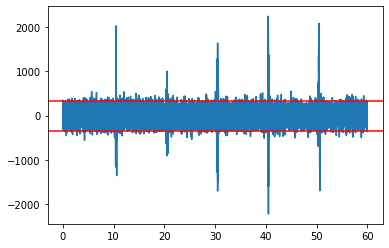

In [ ]:
plt.plot('Time','dB',data=data)
plt.axhline(low,color='r')
plt.axhline(up,color='r')

# Isolation Forest

In [8]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [ ]:
# Extract the feature matrix from the DataFrame
standard_scaler = StandardScaler()
np_scaled = standard_scaler.fit_transform(df[['dB']])
X = pd.DataFrame(np_scaled)
# Initialize the Isolation Forest model with some hyperparameters
model = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.01, random_state=42)

# Fit the model to the data
model.fit(X)

# Use the model to predict which data points are anomalies
df['anomaly25'] = pd.Series(model.predict(X))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

0    594070
1      5930
Name: anomaly25, dtype: int64


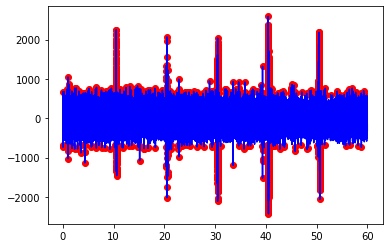

In [ ]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['Time', 'dB']] #anomaly

ax.plot(df['Time'], df['dB'], color='blue')
ax.scatter(a['Time'],a['dB'], color='red')
plt.show()

In [6]:
data = df.copy()
ma = 10
data['dB'] = data['dB'].rolling(ma).mean()
data = data.loc[ma:,:]

In [11]:
# min_max_scaler = MinMaxScaler()
# np_scaled = min_max_scaler.fit_transform(data[['dB']])
# X = pd.DataFrame(np_scaled)
# Initialize the Isolation Forest model with some hyperparameters
model = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.011, random_state=42)

# Fit the model to the data
model.fit(data[['dB']])

# Use the model to predict which data points are anomalies
data['anomaly25'] = pd.Series(model.predict(data[['dB']]))
data['anomaly25'] = data['anomaly25'].map( {1: 0, -1: 1} )
print(data['anomaly25'].value_counts())

0.0    593411
1.0      6569
Name: anomaly25, dtype: int64


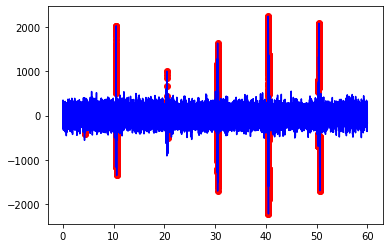

In [ ]:
fig, ax = plt.subplots()

a = data.loc[data['anomaly25'] == 1, ['Time', 'dB']] #anomaly

ax.plot(data['Time'], data['dB'], color='blue')
ax.scatter(a['Time'],a['dB'], color='red')
plt.show()

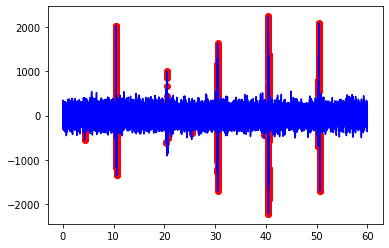

In [12]:
fig, ax = plt.subplots()

a = data.loc[data['anomaly25'] == 1, ['Time', 'dB']] #anomaly

ax.plot(data['Time'], data['dB'], color='blue')
ax.scatter(a['Time'],a['dB'], color='red')
plt.show()

# Autoencoder

In [ ]:
df1 = df.copy()

In [ ]:
df1 = df1[df1['Time']<10]

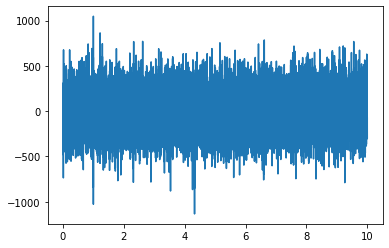

In [ ]:
plt.plot(df1['Time'],df1['dB'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 128)           66560     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 10, 64)           0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 10, 64)            33024     
                                                                 
 lstm_7 (LSTM)               (None, 10, 128)           98816     
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 1)            129       
 tributed)                                            

1.511690616607666

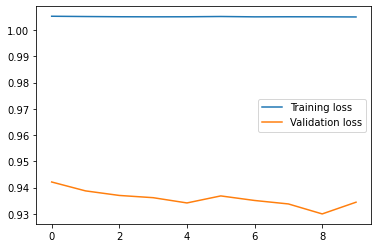

In [18]:
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from matplotlib import pyplot as plt
from keras.models import Model

#Change train data for 5 seconds
train, test = df.loc[df['Time'] <= 10], df.loc[df['Time'] > 10]

scaler = StandardScaler()
scaler = scaler.fit(train[['dB']])

train['dB'] = scaler.transform(train[['dB']])
test['dB'] = scaler.transform(test[['dB']])


seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.


def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequences(train[['dB']], train['dB'], seq_size)
testX, testY = to_sequences(test[['dB']], test['dB'], seq_size)


# define Autoencoder model
#Input shape would be seq_size, 1 - 1 beacuse we have 1 feature. 
seq_size = trainX.shape[1]

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(trainX.shape[1]))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(trainX.shape[2])))

model.compile(optimizer='adam', loss='mse')
model.summary()

#Try another model
# model = Sequential()
# model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(rate=0.2))

# model.add(RepeatVector(trainX.shape[1]))

# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(rate=0.2))
# model.add(TimeDistributed(Dense(trainX.shape[2])))
# model.compile(optimizer='adam', loss='mae')
# model.summary()

# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

model.evaluate(testX, testY)


3125/3125 [==============================] - 24s 8ms/step


(array([4.8500e+02, 3.8930e+03, 9.7780e+03, 1.3952e+04, 1.5154e+04,
        1.3436e+04, 1.1055e+04, 8.5640e+03, 6.4730e+03, 4.8520e+03,
        3.5150e+03, 2.6180e+03, 1.8730e+03, 1.2710e+03, 9.3400e+02,
        7.0600e+02, 4.7800e+02, 3.4200e+02, 2.5300e+02, 1.4300e+02,
        7.1000e+01, 5.6000e+01, 3.1000e+01, 1.2000e+01, 9.0000e+00,
        5.0000e+00, 9.0000e+00, 8.0000e+00, 9.0000e+00, 5.0000e+00]),
 array([0.13694012, 0.24141667, 0.34589322, 0.45036977, 0.55484632,
        0.65932287, 0.76379942, 0.86827597, 0.97275252, 1.07722907,
        1.18170562, 1.28618217, 1.39065873, 1.49513528, 1.59961183,
        1.70408838, 1.80856493, 1.91304148, 2.01751803, 2.12199458,
        2.22647113, 2.33094768, 2.43542423, 2.53990078, 2.64437733,
        2.74885388, 2.85333043, 2.95780698, 3.06228353, 3.16676008,
        3.27123663]),
 <a list of 30 Patch objects>)

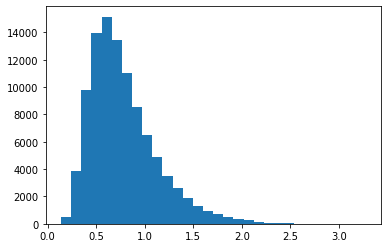

In [19]:
#Anomaly is where reconstruction error is large.
#We can define this value beyond which we call anomaly.
#Let us look at MAE in training prediction

trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)

15625/15625 [==============================] - 112s 7ms/step


(array([1.40669e+05, 2.37830e+05, 8.15910e+04, 2.42090e+04, 6.39200e+03,
        1.89000e+03, 9.17000e+02, 9.02000e+02, 6.59000e+02, 4.57000e+02,
        4.64000e+02, 3.94000e+02, 3.00000e+02, 3.08000e+02, 3.63000e+02,
        4.54000e+02, 2.65000e+02, 2.57000e+02, 3.53000e+02, 2.39000e+02,
        1.54000e+02, 1.19000e+02, 1.16000e+02, 1.84000e+02, 1.38000e+02,
        1.49000e+02, 1.14000e+02, 4.60000e+01, 3.90000e+01, 1.80000e+01]),
 array([ 0.08876425,  0.52011199,  0.95145972,  1.38280746,  1.8141552 ,
         2.24550294,  2.67685068,  3.10819842,  3.53954616,  3.9708939 ,
         4.40224163,  4.83358937,  5.26493711,  5.69628485,  6.12763259,
         6.55898033,  6.99032807,  7.42167581,  7.85302354,  8.28437128,
         8.71571902,  9.14706676,  9.5784145 , 10.00976224, 10.44110998,
        10.87245772, 11.30380545, 11.73515319, 12.16650093, 12.59784867,
        13.02919641]),
 <a list of 30 Patch objects>)

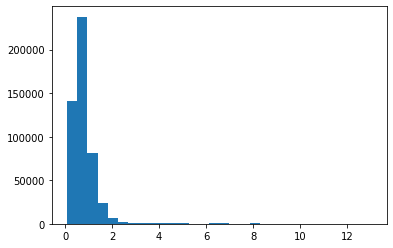

In [20]:
max_trainMAE = 3
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)

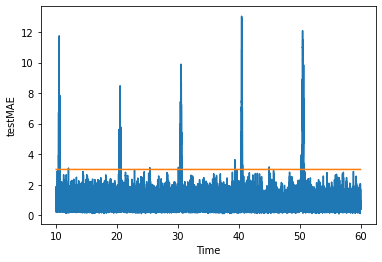

In [21]:
#Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['dB'] = test[seq_size:]['dB']

#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['Time'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['Time'], y=anomaly_df['max_trainMAE'])

anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

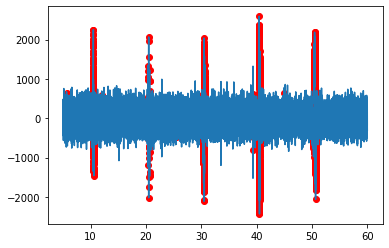

In [15]:
#Plot anomalies
plt.plot(anomaly_df['Time'], scaler.inverse_transform(anomaly_df[['dB']]))
plt.scatter(x=anomalies['Time'], y=scaler.inverse_transform(anomalies[['dB']]), color='r')

In [ ]:
anomalies.head()

,Time,dB,anomaly25,testMAE,max_trainMAE,anomaly
56581,5.658109,2.802685,0,3.090273,3,True
56582,5.658209,3.774043,1,3.144079,3,True
56583,5.658309,3.038166,0,3.195203,3,True
56584,5.658409,2.284628,0,3.191997,3,True
56585,5.658509,2.137452,0,3.151717,3,True
